# NTM - dataframes processing
### Enrico Gavagnin

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects
import os
from matplotlib.patches import Rectangle

from rpy2.robjects.packages import importr
%load_ext rpy2.ipython



## Statistics (R)

In [2]:
%%R 
# -o prop_list -o pv_adj 
rm(list=ls())
library(lme4)
library(car)


stats_R <- function() {

    prop_list <- c('c3pMOD','wDIA','cwDEH','DEN', 'CLS')
    dat <- read.csv("NTM_df_stats.csv", header=T, stringsAsFactors = F)
    # list of properties for the LMER test
    pv_list <- integer(0)
    
#     if (dat$time_win[1] == 12*60*60){
#             rf <- ' ~ exp +(1|rep)'}
#         else{
#             rf <- ' ~ exp +(1|rep)+(1|h)'
#         }
    rf <- ' ~ exp +(1|rep)+(1|h)'
    #rf <- ' ~ exp +(1|rep)'
    for (prop in prop_list){
        model <- lmer(formula(paste(prop,rf)), data = dat)
        #print(summary(model))
        pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
    }

    pv_adj <- p.adjust(pv_list, method="BH")
    names(pv_adj) <- prop_list
  return(pv_adj)
}

R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: carData



# Loop (Filtering - Statistics - Plotting)

In [32]:
# ========== FILTERING ============
reps_discarded = [20,41]


# Total windows in hours
tot_win_h = 24

# Day/night focus
day_night = 'day'

# Down sample number of replicate to 5 replicates
down_sample = False

# Nest focus
nest_focus = True

# Social network properties list
prop_list = ['c3pMOD','wDIA','cwDEH','DEN', 'CLS']

plot_fld_path = 'plots/' + '_'.join(prop_list)  + '_' + day_night + '_NF_' + str(nest_focus) +'_lenght_inter/'
if down_sample==True:
    plot_fld_path = 'plots/' + '_'.join(prop_list)  + '_' + day_night + '_NF_' + str(nest_focus) + '_DS_' + str(down_sample) + '/'

if not os.path.exists(plot_fld_path):
            os.makedirs(plot_fld_path)


# Load the condensation times 
cond_data = pd.read_excel('detection_data_export.xlsx').drop([0,1], axis=0).set_index('REPLICATE').iloc[:,21:-1]
cond_data = cond_data.rename(columns={c: c.hour for c in list(cond_data.columns)})

        
# initialise summary df
pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect'] + prop_list)

for data_file_name in ['data/prop_data_12_6_4_3_2_1_#inter_nest_21042022.pkl']:
    df = pd.read_pickle(data_file_name)

    if '#inter_' in data_file_name:
        link_type = '#inter'
    elif 'length_inter_'in data_file_name:
        link_type = 'length_inter'

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:

        for time_win in [1, 2, 3, 4, 6]:
            print(time_win)
            max_gap = 10 #s
            
            
            df_filt = df.loc[(df.time_win==3600 * time_win) &
                             (df.max_gap==max_gap) & 
                             (df.exp.isin([exp+'a',exp+'b'])) &
                             (~df.rep.isin(reps_discarded))]
            df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
            
            if day_night == 'day':
                df_filt = df_filt.loc[(df_filt['h'] >= 9) & (df_filt['h'] + time_win <= 21)]
                
            elif day_night == 'night':
                df_filt = df_filt.loc[(df_filt['h'] + time_win <= 9) | (df_filt['h'] >= 21)]
                
            elif day_night == 'day_9':
                df_filt = df_filt[(df_filt.h == 9)]

               
            # Remove the time slots with condensations 
            # (exclude also the corresponding time slot in the other experiemnt)
            df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'a', 
                                                  [np.mod(df_filt.h.loc[idx] + h, 24) 
                                                   for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                                   ).sum() == 0 for idx in df_filt.index]]
            df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'b',
                                                  [np.mod(df_filt.h.loc[idx] + h, 24) 
                                                   for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                                   ).sum() == 0 for idx in df_filt.index]]

            # Remove overlapping time_window
            df_filt = df_filt.loc[df_filt.h%time_win == 9%time_win]
            
            # Sort df_filt
            df_filt = df_filt.sort_values(['rep','h'])
            
            if down_sample == True:
                df_filt = df_filt.loc[(df_filt.rep.isin(np.random.choice(df_filt.rep.unique(),5,replace=False)))]
            
            
            # Test that df matches the a-b structure
            if df_filt.rep.diff().iloc[1::2].sum() != 0:
                raise Exception('df_filt not having a-b strcture!')

            
            # Export dataframe for stats
            df_filt.to_csv('NTM_df_stats.csv')

            
            # ============ STATISTICS ============
            %R -o pv_adj pv_adj <- stats_R()


            # ============= PLOTTING =============
            pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}

            # Save p values on the summary dataframerme

            pv_dict['exp'] = exp
            pv_dict['time_win (h)'] = time_win
            pv_dict['link_type'] = link_type
            pv_dict['pv/effect'] = 'pv'
            pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(pv_dict, index=[0])], ignore_index=True)

            # Raw data specific property
            fig, axs = plt.subplots(2, len(prop_list), 
                                    gridspec_kw={'height_ratios': [2.5, 1]},
                                    figsize=(15,10))

            effect_dict = {}
            for idx_p, p in enumerate(prop_list):

                # dataframe for a-b comparison
                df_ab = pd.DataFrame()
                if exp in ['MOD', 'DEN']:   
                    df_ab.insert(0, 'B', list(df_filt[p].iloc[::2]))
                    df_ab.insert(1, 'A', list(df_filt[p].iloc[1::2]))
                else:
                    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
                    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
                
                    
                
                df_ab['B-A'] = df_ab.B-df_ab.A


                # Plotting
                vals, names, xs = [],[],[]
                for i, col in enumerate(['A', 'B']):
                    vals.append(df_ab[col].values)
                    names.append(col)
                    xs.append(np.random.normal(i + 1, 0.04, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

                # box plot
                box_plot = axs[0,idx_p].boxplot(vals, labels=names, showmeans=True, widths=0.6)

                # scatter plot
                for x, val in zip(xs, vals):
                    axs[0, idx_p].scatter(x, val, alpha=0.4)

                # step_line plot
                for idx_step_line in range(len(df_ab)):
                    axs[0, idx_p].plot([1, 2], [df_ab.A.iloc[idx_step_line], df_ab.B.iloc[idx_step_line]], alpha=0.1,
                                       color = 'r' if df_ab['B-A'].iloc[idx_step_line]<0 else 'b')

                means = df_ab.mean()
                stds =  df_ab.std()
                axs[0, idx_p].set_title(p)

                # statistical annotation

                if pv_dict[p]<=0.05:
                    stat_sign = '*' + int(pv_dict[p]<=0.01)*'*' + int(pv_dict[p]<=0.001)*'*' + int(pv_dict[p]<=0.0001)*'*'
                    x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
                    mm =np.max(df_ab.max())
                    y, h, col = 1.01*mm, 0.005*mm, 'k'
                    axs[0, idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                    axs[0, idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=17)

                # save relative effect (mean of deltas / total mean)
                effect_dict[p] = df_ab['B-A'].mean() / pd.concat([df_ab['A'], df_ab['B']]).mean()
                effect_dict[p + '_std_error'] = df_ab['B-A'].std() / np.abs(pd.concat([df_ab['A'], df_ab['B']]).mean() * np.sqrt(len(df_ab)))
                
                # Histogram of difference
                if False: # Choose between absolute difference histogram or relative mean effect
                    axs[1, idx_p].hist(df_ab['B-A'],alpha=0.4, color = 'gray')
                    axs[1, idx_p].scatter(df_ab['B-A'], abs(np.random.normal(0, 1, df_ab['B-A'].values.shape[0])), color = 'gray', alpha = 0.5)
                    axs[1, idx_p].set_xlim([-1.1*np.max(abs(df_ab['A-B'])), 1.1*np.max(abs(df_ab['B-A']))])
                    axs[1, idx_p].plot([df_ab['B-A'].mean(), df_ab['B-A'].mean()], [0, axs[1, idx_p].get_ylim()[1]], color='r', alpha = 0.3)
                    plt.tight_layout()
                    
                else:
                    axs[1, idx_p].bar([0], [effect_dict[p]], yerr= effect_dict[p + '_std_error'], alpha=0.4, color  = )
                    #axs[1, idx_p].scatter(df_ab['A-B'], abs(np.random.normal(0, 1, df_ab['A-B'].values.shape[0])), color = 'gray', alpha = 0.5)
                    axs[1, idx_p].set_ylim([-0.15, 0.15])
                    axs[1, idx_p].set_title('Relative effect')
                    axs[1, idx_p].set_xticks([0],['B - A'])
                    #axs[1, idx_p].plot([df_ab['A-B'].mean(), df_ab['A-B'].mean()], [0, axs[1, idx_p].get_ylim()[1]], color='r', alpha = 0.3)
                    plt.tight_layout()


            # Save effects on the summary dataframe
            effect_dict['exp'] = exp
            effect_dict['time_win (h)'] = time_win
            effect_dict['link_type'] = link_type
            effect_dict['pv/effect'] = 'effect'
            pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(effect_dict, index=[0])], ignore_index=True)
            

            title = 'exp: ' + exp + ', tw: ' + str(time_win) + 'h' + ', n: ' + str(len(df_ab)) + ', reps: ' + str(len(df_filt.rep.unique())) +  ', max_gap: ' + str(max_gap) + 's, links:' + link_type
            file_name = 'dist_comp_exp_' + exp + '_tw_' + str(time_win) + '_links_' + link_type
            
            fig = plt.suptitle(title, fontweight="bold")
            plt.tight_layout()
            plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)
            plt.close()


1


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



2


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



3


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



4


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



6
1


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



2


R[write to console]: boundary (singular) fit: see ?isSingular



3


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



4


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



6
1


R[write to console]: boundary (singular) fit: see ?isSingular



2


R[write to console]: boundary (singular) fit: see ?isSingular



3


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



4


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



6
1


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



2


R[write to console]: boundary (singular) fit: see ?isSingular



3


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



4


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



6


In [19]:
exp_list =['MOD','DIA']
effect_df[[prop + '_std_error' for prop in prop_list]]

,c3pMOD_std_error,wDIA_std_error,cwDEH_std_error,DEN_std_error,CLS_std_error
time_win (h),,,,,
1,-0.020642,-0.022018,-0.017020,-0.017843,-0.017128
2,-0.030137,-0.031680,-0.021122,-0.019184,-0.029761
3,-0.038728,-0.031058,-0.023576,-0.021241,-0.033709
4,-0.044141,-0.039542,-0.025287,-0.021218,-0.035290
6,-0.050794,-0.051779,-0.028203,-0.023821,-0.058179


# 3h time window slot ONLY
## Loop (Filtering - Statistics - Plotting)

In [4]:
# ========== FILTERING ============
reps_discarded = [20,41]


# Total windows in hours
tot_win_h = 24

# Day/night focus
day_night = 'night'

# Nest focus
nest_focus = False

# Social network properties list
prop_list = ['c3pMOD','wDIA','cwDEH','DEN', 'CLS']

plot_fld_path = 'plots/3h_only' + '_'.join(prop_list)  + '_' + day_night + '_NF_' + str(nest_focus) +'/'
if not os.path.exists(plot_fld_path):
            os.makedirs(plot_fld_path)


# Load the condensation times 
cond_data = pd.read_excel('detection_data_export.xlsx').drop([0,1], axis=0).set_index('REPLICATE').iloc[:,21:-1]
cond_data = cond_data.rename(columns={c: c.hour for c in list(cond_data.columns)})

        
# initialise summary df
pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect'] + prop_list)

#df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()
for data_file_name in ['data/prop_data_3_#inter_NF_T_F.pkl']:
    df = pd.read_pickle(data_file_name)

    if '_#inter_' in data_file_name:
        link_type = '#inter'
    elif '_length_inter_'in data_file_name:
        link_type = 'length_inter'

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:

        for time_win in [3]:
            max_gap = 10 #s
            
            
            df_filt = df.loc[(df.time_win==3600 * time_win) &
                             (df.nest_focus== nest_focus) &
                             (df.max_gap==max_gap) & 
                            (df.exp.isin([exp+'a',exp+'b'])) & 
                            (~df.rep.isin(reps_discarded))]
            df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
            
            # Choose only non overlapping time windows
            df_filt = df_filt.loc[(df_filt['h']%3 ==0)]
            
            if day_night == 'day':
                df_filt = df_filt.loc[(df_filt['h'] >= 9) & (df_filt['h'] + time_win <= 21)]
                
            elif day_night == 'night':
                df_filt = df_filt.loc[(df_filt['h'] + time_win <= 9) | (df_filt['h'] >= 21)]
                
            elif day_night == 'day_9':
               
                df_filt = df_filt[(df_filt.h == 9)]

               
            # Remove the time slots with condensations 
            # (exclude also the corresponding time slot in the other experiemnt)
            df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'a', 
                                                  [np.mod(df_filt.h.loc[idx] + h, 24) 
                                                   for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                                   ).sum() == 0 for idx in df_filt.index]]
            df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'b',
                                                  [np.mod(df_filt.h.loc[idx] + h, 24) 
                                                   for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                                   ).sum() == 0 for idx in df_filt.index]]

            df_filt = df_filt.sort_values(['rep','h'])
            
            # Test that df matches the a-b structure
            if df_filt.rep.diff().iloc[1::2].sum() != 0:
                raise Exception('df_filt not having a-b strcture!')

            
            # Export dataframe for stats
            df_filt.to_csv('NTM_df_stats.csv')

            

            # ============ STATISTICS ============
            %R -o pv_adj pv_adj <- stats_R()


            # ============= PLOTTING =============
            pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}

            # Save p values on the summary dataframerme

            pv_dict['exp'] = exp
            pv_dict['time_win (h)'] = time_win
            pv_dict['link_type'] = link_type
            pv_dict['pv/effect'] = 'pv'
            pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(pv_dict, index=[0])], ignore_index=True)

            # Raw data specific property
            fig, axs = plt.subplots(2, len(prop_list), 
                                    gridspec_kw={'height_ratios': [2.5, 1]},
                                    figsize=(15,10))

            effect_dict = {}
            for idx_p, p in enumerate(prop_list):

                # dataframe for a-b comparison
                df_ab = pd.DataFrame()
                df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
                df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
                df_ab['A-B'] = df_ab.A-df_ab.B


                # Plotting
                vals, names, xs = [],[],[]
                for i, col in enumerate(['A', 'B']):
                    vals.append(df_ab[col].values)
                    names.append(col)
                    xs.append(np.random.normal(i + 1, 0.04, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

                # box plot
                box_plot = axs[0,idx_p].boxplot(vals, labels=names, showmeans=True, widths=0.6)

                # scatter plot
                for x, val in zip(xs, vals):
                    axs[0, idx_p].scatter(x, val, alpha=0.4)

                # step_line plot
                for idx_step_line in range(len(df_ab)):
                    axs[0, idx_p].plot([1, 2], [df_ab.A.iloc[idx_step_line], df_ab.B.iloc[idx_step_line]], alpha=0.1,
                                       color = 'r' if df_ab['A-B'].iloc[idx_step_line]<0 else 'b')

                means = df_ab.mean()
                stds =  df_ab.std()
                axs[0, idx_p].set_title(p)

                # statistical annotation

                if pv_dict[p]<=0.05:
                    stat_sign = '*' + int(pv_dict[p]<=0.01)*'*' + int(pv_dict[p]<=0.001)*'*' + int(pv_dict[p]<=0.0001)*'*'
                    x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
                    mm =np.max(df_ab.max())
                    y, h, col = 1.01*mm, 0.005*mm, 'k'
                    axs[0, idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                    axs[0, idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=17)

                # save relative effect (mean of deltas / total mean)
                effect_dict[p] = df_ab['A-B'].mean() / pd.concat([df_ab['A'], df_ab['B']]).mean()

                # Histogram of difference
                axs[1, idx_p].hist(df_ab['A-B'],alpha=0.4, color = 'gray')
                axs[1, idx_p].scatter(df_ab['A-B'], abs(np.random.normal(0, 1, df_ab['A-B'].values.shape[0])), color = 'gray', alpha = 0.5)
                axs[1, idx_p].set_xlim([-1.1*np.max(abs(df_ab['A-B'])), 1.1*np.max(abs(df_ab['A-B']))])
                axs[1, idx_p].plot([df_ab['A-B'].mean(), df_ab['A-B'].mean()], [0, axs[1, idx_p].get_ylim()[1]], color='r', alpha = 0.3)
                plt.tight_layout()


            # Save effects on the summary dataframe
            effect_dict['exp'] = exp
            effect_dict['time_win (h)'] = time_win
            effect_dict['link_type'] = link_type
            effect_dict['pv/effect'] = 'effect'
            pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(effect_dict, index=[0])], ignore_index=True)



            title = 'exp: ' + exp + ', tw: ' + str(time_win) + 'h' + ', n: ' + str(len(df_ab)) + ', reps: ' + str(len(df_filt.rep.unique())) +  ', max_gap: ' + str(max_gap) + 's, links:' + link_type
            file_name = 'dist_comp_exp_' + exp + '_tw_' + str(time_win) + '_links_' + link_type
            
            fig = plt.suptitle(title, fontweight="bold")
            plt.tight_layout()
            plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)
            plt.close()



R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



In [7]:
pd.read_pickle(data_file_name)

,rep,exp,start,time_win,nest_focus,max_gap,GC,ants,cMOD_communities,cmpMOD_communities,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
0,13,DEHa,2021-09-12 09:00:00,10800,True,10,169,177,"[63, 48, 48, 10]","[62, 48, 48, 10, 1]",...,0.000259,4,2.158824,2,1.1,42.454597,38.514976,335.912795,325.843353,0.036739
1,13,DEHa,2021-09-12 09:00:00,10800,False,10,177,177,"[109, 68]","[106, 68, 1, 1, 1]",...,0.00042,2,0.244444,1,0.129555,25.712869,25.712869,313.428199,313.428199,0.04739
2,13,DEHa,2021-09-12 10:00:00,10800,True,10,170,177,"[48, 46, 33, 28, 15]","[48, 46, 33, 28, 15]",...,0.000234,4,3.083333,2,2.0,41.378919,38.475848,328.220029,322.025959,0.042846
3,13,DEHa,2021-09-12 10:00:00,10800,False,10,177,177,"[87, 77, 11, 2]","[87, 77, 10, 2, 1]",...,0.000394,2,0.287646,1,0.154208,26.545848,26.545848,317.951516,317.951516,0.057253
4,13,DEHa,2021-09-12 11:00:00,10800,True,10,165,177,"[59, 48, 33, 25]","[59, 47, 33, 25, 1]",...,0.000253,3,2.090909,2,1.071429,42.508472,36.697795,351.018676,337.897517,0.051055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3779,56,DENb,2021-12-21 04:00:00,10800,False,10,172,172,"[63, 46, 45, 18]","[63, 46, 44, 18, 1]",...,0.000487,2,0.200631,1,0.131419,24.45311,24.45311,260.384214,260.384214,0.053232
3780,56,DENb,2021-12-21 05:00:00,10800,True,10,166,172,"[55, 54, 36, 21]","[54, 54, 36, 21, 1]",...,0.000357,3,2.101405,2,1.066316,39.916046,34.765404,315.075365,294.334673,0.056236
3781,56,DENb,2021-12-21 05:00:00,10800,False,10,172,172,"[65, 64, 43]","[64, 63, 43, 1, 1]",...,0.00049,2,0.208333,1,0.125,24.300056,24.300056,245.735272,245.735272,0.060098
3782,56,DENb,2021-12-21 06:00:00,10800,True,10,164,172,"[38, 37, 37, 26, 26]","[38, 37, 37, 26, 26]",...,0.000338,3,2.130909,2,1.083916,39.66547,32.849584,286.828216,257.650021,0.036883


## Plotting
### (Properties distributions)

In [23]:
# ========== FILTERING ============
reps_discarded = [20,41]


# Total windows in hours
tot_win_h = 24

# Day/night focus
day_night = 'day+night'

# Down sample number of replicate to 5 replicates
down_sample = False

# Nest focus
nest_focus = True

# Social network properties list
prop_list = ['c3pMOD','wDIA','cwDEH','DEN', 'CLS']

plot_fld_path = 'plots/' + '_'.join(prop_list)  + '_' + day_night + '_NF_' + str(nest_focus) +'_lenght_inter/'
if down_sample==True:
    plot_fld_path = 'plots/' + '_'.join(prop_list)  + '_' + day_night + '_NF_' + str(nest_focus) + '_DS_' + str(down_sample) + '/'

if not os.path.exists(plot_fld_path):
            os.makedirs(plot_fld_path)


# Load the condensation times 
cond_data = pd.read_excel('detection_data_export.xlsx').drop([0,1], axis=0).set_index('REPLICATE').iloc[:,21:-1]
cond_data = cond_data.rename(columns={c: c.hour for c in list(cond_data.columns)})

        
# initialise summary df
pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect'] + prop_list)

for data_file_name in ['data/prop_data_12_6_4_3_2_1_#inter_nest_21042022.pkl']:
    df = pd.read_pickle(data_file_name)

    if '#inter_' in data_file_name:
        link_type = '#inter'
    elif 'length_inter_'in data_file_name:
        link_type = 'length_inter'

    for exp in ['MOD', 'DIA', 'DEN', 'DEH']:

        for time_win in [3]:
            print(time_win)
            max_gap = 10 #s
            
            
            df_filt = df.loc[(df.time_win==3600 * time_win) &
                             (df.max_gap==max_gap) & 
                             (df.exp.isin([exp+'a',exp+'b'])) &
                             (~df.rep.isin(reps_discarded))]
            df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
            
            if day_night == 'day':
                df_filt = df_filt.loc[(df_filt['h'] >= 9) & (df_filt['h'] + time_win <= 21)]
                
            elif day_night == 'night':
                df_filt = df_filt.loc[(df_filt['h'] + time_win <= 9) | (df_filt['h'] >= 21)]
                
            elif day_night == 'day_9':
                df_filt = df_filt[(df_filt.h == 9)]

               
            # Remove the time slots with condensations 
            # (exclude also the corresponding time slot in the other experiemnt)
            df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'a', 
                                                  [np.mod(df_filt.h.loc[idx] + h, 24) 
                                                   for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                                   ).sum() == 0 for idx in df_filt.index]]
            df_filt = df_filt.loc[[(cond_data.loc['s' + str(df_filt.rep.loc[idx]) + '_' + exp + 'b',
                                                  [np.mod(df_filt.h.loc[idx] + h, 24) 
                                                   for h in range(int(df_filt.time_win.loc[idx] / 3600))]] > 0
                                   ).sum() == 0 for idx in df_filt.index]]

            # Remove overlapping time_window
            df_filt = df_filt.loc[df_filt.h%time_win == 9%time_win]
            
            # Sort df_filt
            df_filt = df_filt.sort_values(['rep','h'])
            
            if down_sample == True:
                df_filt = df_filt.loc[(df_filt.rep.isin(np.random.choice(df_filt.rep.unique(),5,replace=False)))]
            
            
            # Test that df matches the a-b structure
            if df_filt.rep.diff().iloc[1::2].sum() != 0:
                raise Exception('df_filt not having a-b strcture!')

            
            # Network size diff (nestB-nestA) as whole network
            ants_diff = (df_filt.ants.diff()/df_filt.ants).iloc[::2]
            
            # Network size diff (nestB-nestA) as connected component
            #ants_diff = (df_filt.GC.diff()/df_filt.GC).iloc[::2]
            
            print('exp: ' + exp + ', mean ant_diff: ' + str(ants_diff.mean()) + ', std ant_diff: ' + str(ants_diff.std()))

3
exp: MOD, mean ant_diff: -0.00395898909458519, std ant_diff: 0.037847345732276494
3
exp: DIA, mean ant_diff: 0.006491715728359852, std ant_diff: 0.047304366482306216
3
exp: DEN, mean ant_diff: -0.002544999703226345, std ant_diff: 0.03929106205133948
3
exp: DEH, mean ant_diff: -0.011975358978599516, std ant_diff: 0.030295850554303165


In [16]:
df_filt

,rep,exp,start,time_win,h,max_gap,GC,ants,cMOD_communities,cmpMOD_communities,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
41,13,DEHa,2021-09-13 00:00:00,10800,0,10,158,177,"[21, 50, 44, 43]","[56, 38, 34, 29, 1]",...,0.000243,3,2.189109,2,1.0982,43.821383,36.898749,360.213748,341.490895,0.048862
97,13,DEHb,2021-09-11 00:00:00,10800,0,10,169,186,"[25, 21, 61, 14, 48]","[64, 47, 35, 22, 1]",...,0.000296,4,2.25,2,1.166667,46.614193,37.255785,388.927161,357.307971,0.016199
42,13,DEHa,2021-09-13 03:00:00,10800,3,10,156,177,"[37, 45, 36, 38]","[66, 48, 40, 1, 1]",...,0.000229,3,2.136795,2,1.090909,42.325052,34.196494,317.374624,292.076248,0.03857
98,13,DEHb,2021-09-11 03:00:00,10800,3,10,172,186,"[24, 26, 23, 99]","[95, 46, 26, 4, 1]",...,0.000312,3,2.096923,2,1.078629,48.170933,40.523066,407.11432,380.717004,0.052309
43,13,DEHa,2021-09-13 06:00:00,10800,6,10,158,177,"[22, 27, 32, 46, 31]","[52, 45, 37, 23, 1]",...,0.000238,5,3.238095,3,2.0,44.388562,37.501157,332.364479,310.252049,0.033137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4685,55,DEHb,2021-12-19 12:00:00,10800,12,10,160,163,"[46, 38, 24, 14, 32, 6]","[45, 38, 31, 26, 20]",...,0.000462,3,2.155556,2,1.090909,35.152934,31.751171,434.121187,423.719412,0.05166
4630,55,DEHa,2021-12-21 15:00:00,10800,15,10,149,157,"[33, 30, 26, 12, 38, 10]","[49, 33, 28, 23, 16]",...,0.00034,3,2.134538,2,1.075714,36.249419,30.638065,304.733002,281.665586,0.039792
4686,55,DEHb,2021-12-19 15:00:00,10800,15,10,154,163,"[44, 12, 21, 41, 26, 10]","[48, 32, 29, 24, 21]",...,0.000382,3,2.071429,2,1.062037,38.720049,31.080725,406.550097,383.837444,0.039516
4631,55,DEHa,2021-12-21 18:00:00,10800,18,10,154,157,"[12, 33, 23, 52, 34]","[49, 37, 34, 25, 9]",...,0.000396,3,2.110256,2,1.069794,35.262523,32.385051,320.182466,309.281844,0.047713


## Plotting
### (Connectivity)

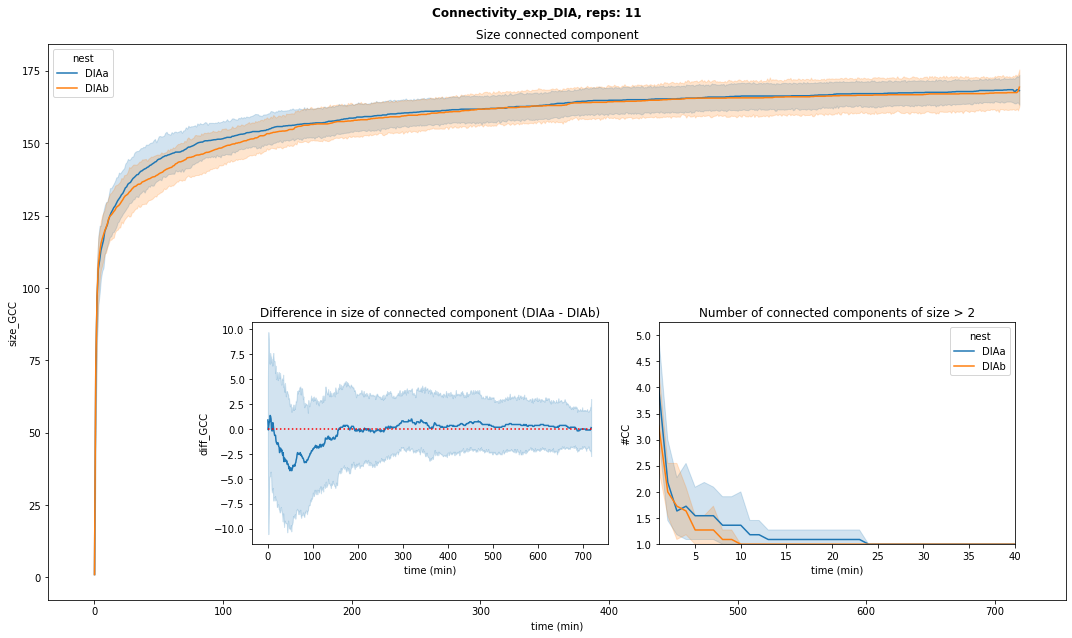

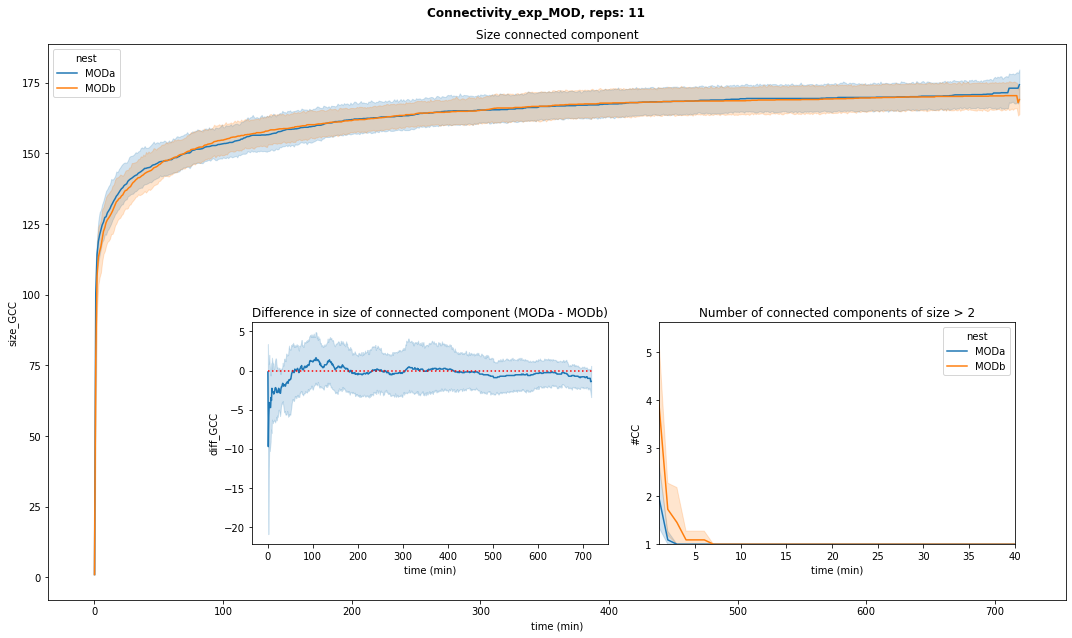

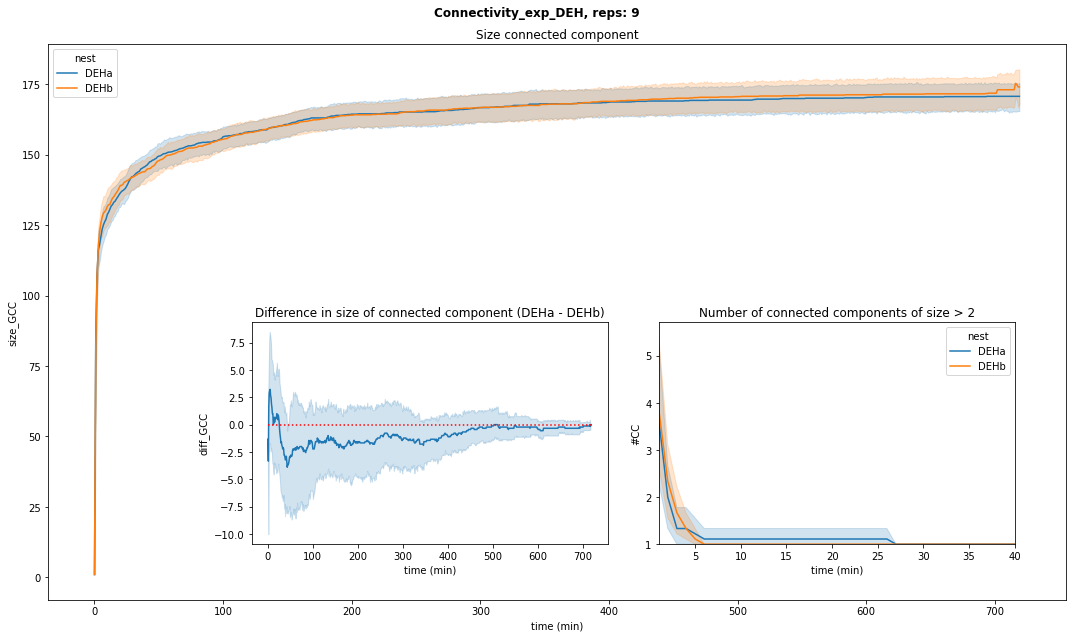

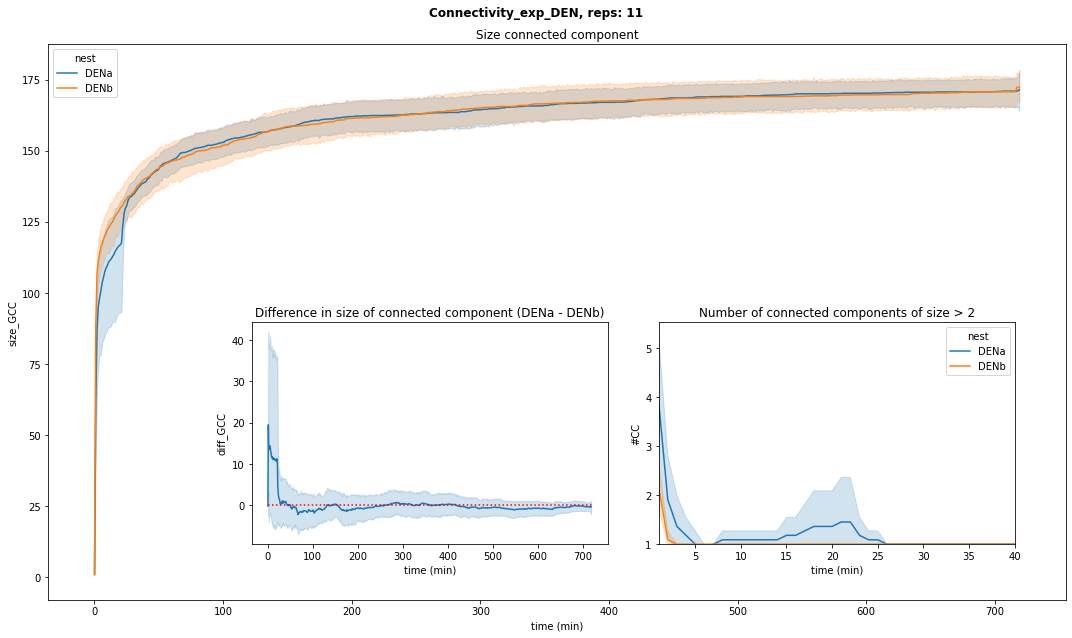

In [5]:

plot_fld_path = 'plots/Connectivity/'


for exp in ['DIA', 'MOD', 'DEH', 'DEN']:
    
    # Reading dataframe of connectivity
    Gcc_df = pd.read_pickle('data/Gcc_NEST.pkl')


    #Filter for the experiement of interest
    Gcc_df = Gcc_df[Gcc_df.rep != 20]
    Gcc_df = Gcc_df[[e[0:3] == exp for e in Gcc_df.exp]]
    Gcc_df.sort_values(['rep','exp'])
    connect_df = pd.DataFrame(columns=['rep', 'nest', 'time (min)', 'size_GCC', '#CC'])

    # treshold minimal partition size
    tresh_part = 2

    # Reformatting dataframe
    for row in range(len(Gcc_df)):
        df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                              'nest': [Gcc_df.exp.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                              'time (min)': Gcc_df.Gcc.iloc[row][1],
                              'size_GCC': [len(cc[0]) for cc in Gcc_df.Gcc.iloc[row][0]],
                              '#CC': [sum([len(p) > tresh_part for p in cc]) for cc in Gcc_df.Gcc.iloc[row][0]]})
        connect_df = pd.concat([connect_df, df_aux], ignore_index=True)

    # Plotting    
    fig, axs = plt.subplots(1, 1)
    title = 'Connectivity_exp_' + exp + ', reps: ' + str(int(len(Gcc_df)/2)) 
    supt = plt.suptitle(title, fontweight="bold")
    # Plot 1 (size GCC)
    sns.lineplot(data=connect_df, x="time (min)", y="size_GCC", hue="nest", ax=axs)
    axs.set_title('Size connected component')
    plt.tight_layout()
    axs_i_r = axs.inset_axes([0.6,0.1,0.35,0.4])

    # Plot 1 (number CC)
    sns.lineplot(data=connect_df, x="time (min)", y="#CC", hue="nest", ax=axs_i_r)
    axs_i_r.set_title('Number of connected components of size > ' + str(tresh_part))
    axs_i_r.set_xlim([1,40])
    axs_i_r.set_ylim(bottom=1)
    plt.tight_layout()

    # ====================================
    # Difference in size of GCC
    diff_connect_df = pd.DataFrame(columns=['rep', 'time (min)', 'diff_GCC'])

    def diff_list_GCC(A, B):
        A_len = [len(a) for a in A]
        B_len = [len(b) for b in B]
        return [A_len[i] - B_len[i] for i in range(min(len(A), len(B)))]

    # Reformatting dataframe
    for row in range(0, len(Gcc_df) -1, 2):
        diff_GCC = diff_list_GCC(Gcc_df.Gcc.iloc[row][0], Gcc_df.Gcc.iloc[row + 1][0])
        df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(diff_GCC),
                              'time (min)': range(len(diff_GCC)),
                              'diff_GCC': diff_GCC})
        diff_connect_df = pd.concat([diff_connect_df, df_aux], ignore_index=True)

    # Plotting    
    # Plot 3 (diff size GCC)
    axs_i_l = axs.inset_axes([0.2,0.1,0.35,0.4])
    sns.lineplot(data=diff_connect_df, x="time (min)", y="diff_GCC", ax=axs_i_l)
    axs_i_l.plot([0, 720], [0, 0], ':r')
    axs_i_l.set_title('Difference in size of connected component (' + Gcc_df.exp.iloc[0] + ' - ' + Gcc_df.exp.iloc[1] + ')')
    plt.tight_layout()

    file_name = 'Connectivity_exp_' + exp 

    #Savefig
    plt.savefig(plot_fld_path + file_name + '.png', facecolor='white', transparent=False)



## Plotting
### (Relative difference)

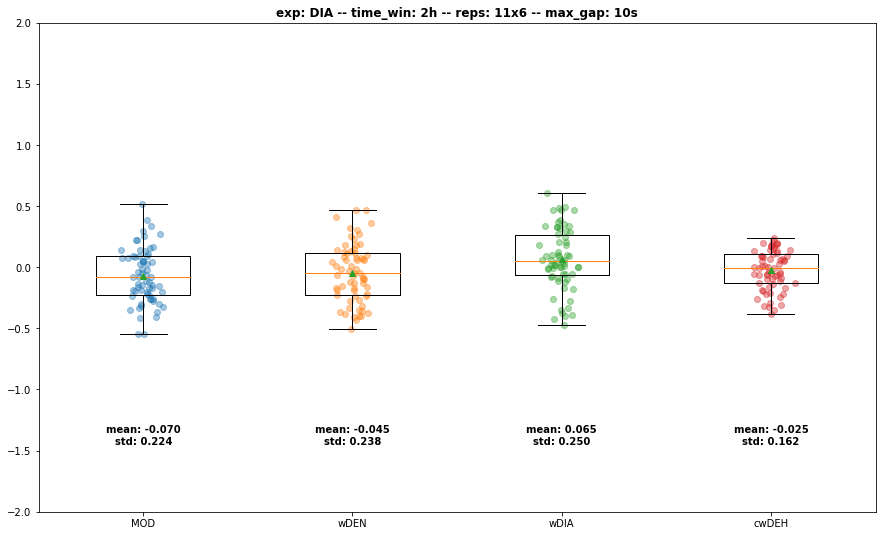

In [231]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'cwDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")

## p-values & effect visualisation

In [74]:
pv_effect_df = df = pd.read_csv('data/pv_effect_df.csv', index_col=0)


for exp in ['MOD', 'DIA', 'DEN', 'DEH']:
    
    for link_type in ['length_inter', '#inter']:
        pv_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                             (pv_effect_df['pv/effect'] == 'pv') & 
                             (pv_effect_df['link_type'] == link_type)].drop(columns=['exp','link_type','pv/effect']).set_index('time_win (h)')

        effect_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                                 (pv_effect_df['pv/effect'] == 'effect') & 
                                 (pv_effect_df['link_type'] == link_type)].drop(columns=['exp','link_type','pv/effect']).set_index('time_win (h)')

        #effect_df[pv_df>0.05] = np.nan

        # Annotation
        sns.set(font_scale = 1.3)
        annot = pv_df.copy()

        for i in range(np.shape(annot)[0]):
            for j in range(np.shape(annot)[1]):
                annot.iloc[i,j] = '(p= {:.4f})\n {:f}'.format(annot.iloc[i,j], effect_df.iloc[i,j])

        annot[pv_df>0.05] = ''
        plt.figure()
        ax = sns.heatmap(effect_df, linewidths=1,
                             linecolor='black',
                             cmap='vlag',
                             center=0,
                             vmin=-0.4,
                             annot_kws={"style": "italic", "weight": "bold"},
                             vmax=0.4,
                             annot = annot, fmt = '',
                             cbar_kws={'label': 'effect'})
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        title = 'stats_summary_exp_' + exp + '_link type_' + link_type
        fig = plt.suptitle(title, fontweight="bold")
        plt.savefig('plots/' + title + '_.png', facecolor='white', transparent=False)
        plt.close()

